In [1]:
import pickle
import glob
from pathlib import Path

from pyprojroot.here import here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

np.random.seed(1010)

In [2]:
import scieco

df_aa = scieco.get_dataframe("aa-v3")

person_rank_year = df_aa[['PersonId', 'Rank', 'Year']].drop_duplicates()

print(f"Loaded the AARC data: {len(df_aa)} people-year rows. We have {len(person_rank_year)} unique person-rank-years.")

/Users/shzh8108/research/clauset/scieco-data/scieco/scieco/__init__.py:52: DtypeWarning: Columns (4,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Loaded the AARC data: 3832022 people-year rows. We have 2682900 unique person-rank-years.


In [3]:
def augment_parameters_df_with_prod_averages(df_parameters, df_trajectories): 
    df2 = df_parameters.copy()
    
    for i, row in df2.iterrows():
        start = row.cutoff_start
        end = row.cutoff_end

        career_stage = df_trajectories[
            (df_trajectories.CareerAgeZero >= start) &
            (df_trajectories.CareerAgeZero < end) # excludes end to match what happens in fit/src/lib_fit_models.py
        ]
        df2.loc[i, 'avg_q_adj_delta'] = career_stage.q_adj_delta.mean()
        df2.loc[i, 'avg_pubs_adj'] = career_stage.pubs_adj.mean()


        # Cluster robust standard errors
        n_people = career_stage["PersonId"].nunique()
        df2.loc[i, 'se_q_adj_delta'] = career_stage.groupby("PersonId")["q_adj_delta"].mean().std(ddof=1) / np.sqrt(n_people)
        df2.loc[i, 'se_pubs_adj'] = career_stage.groupby("PersonId")["pubs_adj"].mean().std(ddof=1) / np.sqrt(n_people)


    df2['last_stage'] = False
    df2.loc[i, 'last_stage'] = True
    df2['nth_stage'] = range(len(df2))
    df2['nth_from_last_stage'] = range(len(df2) - 1, -1, -1)
    
    return df2


def get_promotion_df_for_field(field_trajectories):

    df_field_with_ranks = field_trajectories.merge(person_rank_year, on=['PersonId', 'Year'])
    df_field_with_promotion = df_field_with_ranks[df_field_with_ranks.groupby(['PersonId']).Rank.transform('nunique') == 3].copy()
    df_field_with_promotion['NextYearsRank'] = df_field_with_promotion.groupby('PersonId').Rank.shift(-1)
    df_field_with_promotion['WasPromotedFromAssistant'] = (df_field_with_promotion.Rank == 'Assistant Professor') & (df_field_with_promotion.NextYearsRank == 'Associate Professor')
    
    # Add the years that someone was promoted, so we can compute the deltas relative to that time
    df_field_with_promotion = df_field_with_promotion.merge(
        df_field_with_promotion[df_field_with_promotion.WasPromotedFromAssistant][['PersonId', 'CareerAgeZero']].rename(columns={'CareerAgeZero': 'CareerAgePromoted'}),
        on='PersonId'
    )
    
    df_field_with_promotion['TenureAge'] = df_field_with_promotion.CareerAgeZero - df_field_with_promotion.CareerAgePromoted
    
    return df_field_with_promotion

In [4]:
fields_to_display_names = {
    "biological_sciences": "Biological\nSciences",
    "sociology": "Sociology",
    "management": "Management",
    "mathematics": "Mathematics",
    "computer_science": "CS (AARC)",
    "economics": "Economics",
    "electrical_engineering": "Electrical\nEngineering",
    "chemistry": "Chemistry",
    "psychology": "Psychology",
    "mechanical_engineering": "Mechanical\nEngineering",
    "political_science": "Political Science",
    "history": "History",
    "physics": "Physics",
}

In [5]:
#######################################
# Import data
#######################################

# Empirical trajectories
df_traj_all = pd.read_csv(here("input/import/all-trajectories.csv"))

# Fitted results fits
with open(here("input/fit/results-all-trajectories.pickle"), "rb") as f:
    results_dblp = pickle.load(f)

# AARC trajectories
aarc = {}

for path in Path(here("input/import/")).glob("aarc_trajectories_*.csv"):
    field = path.stem.partition("_")[2].partition("_")[2]


    result_path = here(f"input/fit/results-{path.stem}.pickle")
    with open(result_path, "rb") as f:
        result = pickle.load(f)

    df_trajectories_field = pd.read_csv(path)
    mle_cutoffs = result['df_reg_scores'].sort_values(by='aic_varying').cutoffs.iloc[0]
    mle_cutoff_parameters = result['regression_for_cutoffs'][mle_cutoffs]
    df_parameters = pd.DataFrame(mle_cutoff_parameters)
    df_parameters['field'] = field
    df_parameters['display_field'] = fields_to_display_names[field]

    df_parameters = augment_parameters_df_with_prod_averages(df_parameters, df_trajectories_field)
    df_promotions = get_promotion_df_for_field(df_trajectories_field)

    print(f"Loading {field}... there were {df_promotions.PersonId.nunique()} people who were both seen starting and promoted in the AARC. Person-years of data: {len(df_promotions)}.")
    
    aarc[field] = {
        'trajectories': df_trajectories_field,
        'promotions': df_promotions,
        'results': result,
        'mle_cutoffs': mle_cutoffs,
        'mle_cutoff_parameters': df_parameters,
        'display_field': fields_to_display_names[field],
    }

Loading biological_sciences... there were 85 people who were both seen starting and promoted in the AARC. Person-years of data: 823.
Loading sociology... there were 34 people who were both seen starting and promoted in the AARC. Person-years of data: 344.
Loading physics... there were 82 people who were both seen starting and promoted in the AARC. Person-years of data: 807.
Loading management... there were 45 people who were both seen starting and promoted in the AARC. Person-years of data: 442.
Loading mathematics... there were 132 people who were both seen starting and promoted in the AARC. Person-years of data: 1294.
Loading computer_science... there were 47 people who were both seen starting and promoted in the AARC. Person-years of data: 469.
Loading economics... there were 43 people who were both seen starting and promoted in the AARC. Person-years of data: 415.
Loading electrical_engineering... there were 38 people who were both seen starting and promoted in the AARC. Person-yea

In [6]:
mle_cutoffs_dblp = results_dblp['df_reg_scores'].sort_values(by='aic_varying').cutoffs.iloc[0]
mle_cutoff_parameters_dblp = results_dblp['regression_for_cutoffs'][mle_cutoffs_dblp]

df_parameters_dblp = pd.DataFrame(mle_cutoff_parameters_dblp)
df_parameters_dblp['field'] = 'cs_dblp'
df_parameters_dblp['display_field'] = 'CS (dblp)'
df_parameters_dblp = augment_parameters_df_with_prod_averages(df_parameters_dblp, df_traj_all.rename(columns={'dblp': 'PersonId'}))

df_parameters_dblp

,cutoffs,cutoff_start,cutoff_end,alpha,mode_beta,mode_mu,nll_mode,nll_mode_fixed,n,field,display_field,avg_q_adj_delta,avg_pubs_adj,se_q_adj_delta,se_pubs_adj,last_stage,nth_stage,nth_from_last_stage
0,"(4, 7, 13)",0,4.0,4.454494,0.805997,-0.372357,22029.397235,22155.408981,8015,cs_dblp,CS (dblp),0.831385,6.265200,0.035469,0.103758,False,0,3
1,"(4, 7, 13)",4,7.0,4.252503,0.725397,0.070498,15397.188832,15410.774408,5625,cs_dblp,CS (dblp),-0.457994,7.665273,0.045678,0.129295,False,1,2
2,"(4, 7, 13)",7,13.0,3.780789,0.726605,-0.625005,23254.155656,23278.874268,8923,cs_dblp,CS (dblp),-0.289809,6.692728,0.032422,0.130856,False,2,1
3,"(4, 7, 13)",13,inf,3.520843,0.754282,-0.020581,15123.923068,15165.220071,5965,cs_dblp,CS (dblp),-0.204647,6.353305,0.046661,0.170607,True,3,0


In [7]:
for field in aarc.keys():
    print(f"MLE cutoffs for {field}: {aarc[field]['mle_cutoffs']}")

MLE cutoffs for biological_sciences: (1, 7)
MLE cutoffs for sociology: (1, 7, 9)
MLE cutoffs for physics: (4, 8, 10)
MLE cutoffs for management: (1, 3, 8)
MLE cutoffs for mathematics: (3, 7)
MLE cutoffs for computer_science: (2, 5, 9)
MLE cutoffs for economics: (1, 2, 6)
MLE cutoffs for electrical_engineering: (1, 2, 7)
MLE cutoffs for chemistry: (1, 3, 6)
MLE cutoffs for psychology: (2, 6, 7)
MLE cutoffs for mechanical_engineering: (1, 3, 6)
MLE cutoffs for political_science: (1, 6)
MLE cutoffs for history: (6, 8, 10)


In [8]:
df_all_fields_params = pd.concat([field['mle_cutoff_parameters'] for field in aarc.values()])
print(df_all_fields_params.shape)

df_all_fields_params.head()

(49, 18)


,cutoffs,cutoff_start,cutoff_end,alpha,mode_beta,mode_mu,nll_mode,nll_mode_fixed,n,field,display_field,avg_q_adj_delta,avg_pubs_adj,se_q_adj_delta,se_pubs_adj,last_stage,nth_stage,nth_from_last_stage
0,"(1, 7)",0,1.0,1.843758,0.600000,-0.08,4264.747113,4264.747113,2391,biological_sciences,Biological\nSciences,0.070682,2.298202,0.045639,0.054630,False,0,2
1,"(1, 7)",1,7.0,1.945976,0.666667,0.24,18617.089666,18658.380912,9982,biological_sciences,Biological\nSciences,0.079744,2.588660,0.021570,0.059458,False,1,1
2,"(1, 7)",7,inf,1.688694,0.666667,0.04,3709.164246,3724.700613,2122,biological_sciences,Biological\nSciences,-0.178605,2.718662,0.051492,0.105212,True,2,0
0,"(1, 7, 9)",0,1.0,1.557709,0.000000,0.19,1788.143881,1821.376871,1239,sociology,Sociology,0.169492,1.388216,0.050607,0.046230,False,0,3
1,"(1, 7, 9)",1,7.0,1.527719,0.500000,-0.03,8295.505075,8295.505075,5317,sociology,Sociology,0.059620,1.772804,0.025520,0.052922,False,1,2


In [9]:
c1 = "#6CA6C1"
c2 = "#2B2118"

def plot_parameterized_plot(ax, df_params):
    x_var = 'nth_stage'
    ax.scatter(df_params[x_var], df_params.alpha, color=df_params.last_stage.apply(lambda x: c1 if x else c2))

    for (x0, y0), (x1, y1), last_arrow in zip(
        zip(df_params[x_var][:-1], df_params.alpha[:-1]),
        zip(df_params[x_var][1:], df_params.alpha[1:]),
        df_params.last_stage[1:]
    ):
        ax.annotate(
            "", 
            xy=(x1, y1), xycoords="data",
            xytext=(x0, y0), textcoords="data",
            arrowprops=dict(arrowstyle="->", color="gray", lw=3 if last_arrow else 1)
        )

    return ax

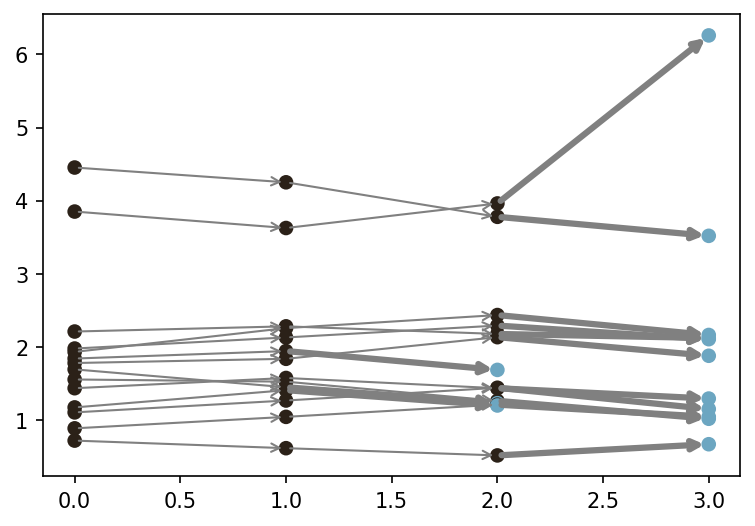

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)

plot_parameterized_plot(ax, df_parameters_dblp)

for field in aarc.keys():
    plot_parameterized_plot(ax, aarc[field]['mle_cutoff_parameters'])
    

In [12]:
df_all_fields = pd.concat([aarc[field]['trajectories'] for field in aarc.keys()])

# AARC has asked us to scramble the PersonIds
uniq_person_ids = df_all_fields.PersonId.unique().copy()

np.random.seed(1010)
np.random.shuffle(uniq_person_ids)

person_id_remap = {x: i for i, x in enumerate(uniq_person_ids)}
df_all_fields['PersonId'] = df_all_fields.PersonId.apply(person_id_remap.get)

df_all_fields_with_publications = df_all_fields[df_all_fields.HasPublications]

print(len(df_all_fields), df_all_fields.PersonId.nunique())
print(len(df_all_fields_with_publications), df_all_fields_with_publications.PersonId.nunique())


df_all_fields.head()

145105 23609
102473 22952


,PersonId,Year,pubs_adj,StartYear,Field,CareerAgeZero,HasPublications,pubs_adj_next,q_adj_delta
0,11945,2013,7.0,2013,Biological Sciences,0,True,5.0,-2.0
1,11945,2014,5.0,2013,Biological Sciences,1,True,6.0,1.0
2,11945,2015,6.0,2013,Biological Sciences,2,True,6.0,0.0
3,11945,2016,6.0,2013,Biological Sciences,3,True,4.0,-2.0
4,11945,2017,4.0,2013,Biological Sciences,4,True,5.0,1.0


In [13]:
df_params = df_parameters_dblp
x_var = 'avg_q_adj_delta'

def compute_delta_for_variable(df_params, x_var = 'alpha'):
    deltas = []
    
    for x0, x1, nth_from_last_stage, in zip(
        df_params[x_var][:-1],
        df_params[x_var][1:],
        df_params.nth_from_last_stage[1:]
    ):
        delta_var = x1 - x0
        deltas.append({
            'delta': delta_var,
            'nth_from_last_stage': nth_from_last_stage,
            'varname': x_var
        })
    
    
    return pd.DataFrame(deltas)

alpha_deltas = df_all_fields_params.groupby('field').apply(compute_delta_for_variable).reset_index()

alpha_deltas.head()

,field,level_1,delta,nth_from_last_stage,varname
0,biological_sciences,0,0.102218,1,alpha
1,biological_sciences,1,-0.257282,0,alpha
2,chemistry,0,0.151445,2,alpha
3,chemistry,1,0.162413,1,alpha
4,chemistry,2,-0.185844,0,alpha


Text(0.5, 0, 'Difference in alpha between last and second-to-last stage')

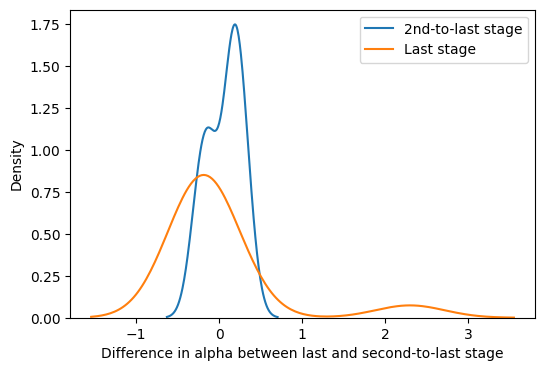

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.kdeplot(alpha_deltas[alpha_deltas.nth_from_last_stage == 1].delta, ax=ax, label="2nd-to-last stage")
sns.kdeplot(alpha_deltas[alpha_deltas.nth_from_last_stage == 0].delta, ax=ax, label="Last stage")

ax.legend()
ax.set_xlabel("Difference in alpha between last and second-to-last stage")

## Figure: does variance drop or shrink between the second-to-last and last stages across fields? $\alpha_{N-1}$ vs. $\alpha_N$

In [15]:
df_second_to_last = df_all_fields_params[df_all_fields_params.nth_from_last_stage == 1]
df_last = df_all_fields_params[df_all_fields_params.nth_from_last_stage == 0]

df_second_to_last.head()

,cutoffs,cutoff_start,cutoff_end,alpha,mode_beta,mode_mu,nll_mode,nll_mode_fixed,n,field,display_field,avg_q_adj_delta,avg_pubs_adj,se_q_adj_delta,se_pubs_adj,last_stage,nth_stage,nth_from_last_stage
1,"(1, 7)",1,7.0,1.945976,0.666667,0.24,18617.089666,18658.380912,9982,biological_sciences,Biological\nSciences,0.079744,2.588660,0.021570,0.059458,False,1,1
2,"(1, 7, 9)",7,9.0,1.265823,0.500000,0.07,1173.431938,1173.431938,853,sociology,Sociology,-0.052755,1.561547,0.056222,0.092019,False,2,1
2,"(4, 8, 10)",8,10.0,3.963604,0.863636,0.88,2116.948558,2123.617285,813,physics,Physics,0.295203,7.466175,0.522543,0.661677,False,2,1
2,"(1, 3, 8)",3,8.0,1.444444,0.000000,-0.01,5256.166330,5256.166330,3843,management,Management,0.018735,1.425709,0.022720,0.040929,False,2,1
1,"(3, 7)",3,7.0,1.451496,0.500000,-0.24,8887.104035,9205.034728,5869,mathematics,Mathematics,-0.027943,1.763674,0.020096,0.042738,False,1,1


In [16]:
parameter_deltas_to_last_stage = df_second_to_last[['alpha', 'mode_mu', 'mode_beta', 'display_field']].rename(columns={
    'alpha': 'alpha_n-1',
    'mode_mu': 'mu_n-1',
    'mode_beta': 'beta_n-1'
}).merge(
    df_last[['alpha', 'mode_mu', 'mode_beta', 'display_field']].rename(columns={
    'alpha': 'alpha_n',
    'mode_mu': 'mu_n',
    'mode_beta': 'beta_n'
}),
    on='display_field'
)

parameter_deltas_to_last_stage['did_variance_drop'] = parameter_deltas_to_last_stage['alpha_n-1'] > parameter_deltas_to_last_stage['alpha_n']
parameter_deltas_to_last_stage['did_mu_drop'] = parameter_deltas_to_last_stage['mu_n-1'] > parameter_deltas_to_last_stage['mu_n']
parameter_deltas_to_last_stage['did_beta_drop'] = parameter_deltas_to_last_stage['beta_n-1'] > parameter_deltas_to_last_stage['beta_n']


parameter_deltas_to_last_stage_no_phys = parameter_deltas_to_last_stage[parameter_deltas_to_last_stage.display_field != 'Physics']

parameter_deltas_to_last_stage_no_phys

,alpha_n-1,mu_n-1,beta_n-1,display_field,alpha_n,mu_n,beta_n,did_variance_drop,did_mu_drop,did_beta_drop
0,1.945976,0.24,0.666667,Biological\nSciences,1.688694,4.000000e-02,0.666667,True,True,True
1,1.265823,0.07,0.500000,Sociology,1.020899,-7.000000e-02,0.500000,True,True,False
3,1.444444,-0.01,0.000000,Management,1.154278,-2.000000e-02,0.000000,True,True,False
4,1.451496,-0.24,0.500000,Mathematics,1.234111,8.881784e-16,0.500000,True,False,True
5,1.437943,-0.44,0.500000,CS (AARC),1.296844,-5.000000e-02,0.666667,True,False,False
6,1.213851,0.14,0.000000,Economics,1.048239,-2.000000e-02,0.000000,True,True,False
7,2.136076,0.34,0.666667,Electrical\nEngineering,1.881782,-1.500000e-01,0.714286,True,True,False
8,2.294549,0.04,0.800000,Chemistry,2.108705,-7.000000e-02,0.750000,True,True,True
9,2.179819,-0.02,0.750000,Psychology,2.124781,-3.800000e-01,0.800000,True,True,False
10,2.438220,0.30,0.785714,Mechanical\nEngineering,2.165975,-4.000000e-02,0.750000,True,True,True


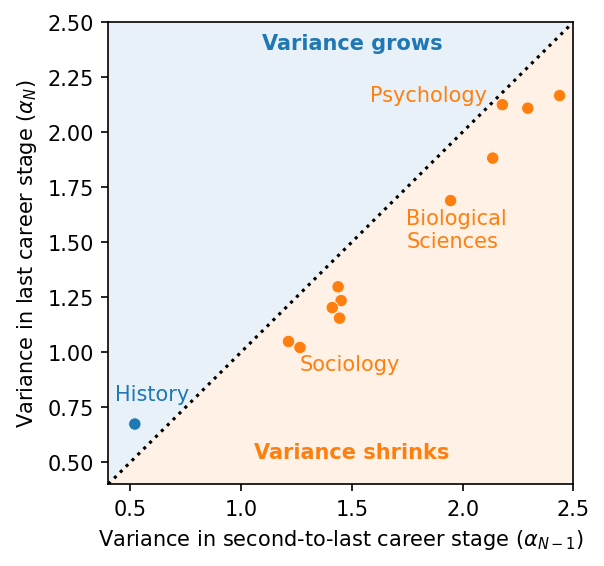

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi =150)

sns.scatterplot(data=parameter_deltas_to_last_stage_no_phys, x='alpha_n-1', y='alpha_n', hue='did_variance_drop', ax=ax, legend=False)

#ax.scatter(df_parameters_dblp[df_parameters_dblp.nth_from_last_stage == 1].alpha, df_parameters_dblp[df_parameters_dblp.nth_from_last_stage == 0].alpha, color=sns.color_palette()[1])

ax.plot([0.4, 2.5], [0.4, 2.5], color='black', linestyle=':')
ax.margins(0)
ax.set_xlabel(r"Variance in second-to-last career stage ($\alpha_{N-1}$)")
ax.set_ylabel(r"Variance in last career stage ($\alpha_N$)")
ax.text(
    1.5, 2.45, "Variance grows",
    ha='center', va='top',
    color=sns.color_palette()[0],
    fontweight='bold',
)
ax.text(
    1.5, 0.5, "Variance shrinks",
    ha='center', va='bottom',
    color=sns.color_palette()[1],
    fontweight='bold',
)

top_triangle = patches.Polygon(
    [[0.4, 0.4], [0.4, 2.5], [2.5, 2.5]],
    closed=True,
    facecolor=sns.color_palette()[0],
    alpha=0.1,
    edgecolor=None
)
ax.add_patch(top_triangle)

bottom_triangle = patches.Polygon(
    [[0.4, 0.4], [2.5, 0.4], [2.5, 2.5]],
    closed=True,
    facecolor=sns.color_palette()[1],
    alpha=0.1,
    edgecolor=None
)
ax.add_patch(bottom_triangle)

fields_to_show = ['History', 'Biological\nSciences', 'Sociology', 'Psychology']

offsets_x = {
    'History': -0.09,
    'Biological\nSciences': -0.2,
    'Psychology': -0.6
}

offsets_y = {
    'History': 0.09,
    'Biological\nSciences': -0.23,
    'Sociology': -0.12
}

for _, row in parameter_deltas_to_last_stage_no_phys.iterrows():
    if row.display_field not in fields_to_show:
        continue
        
    ax.text(
        row["alpha_n-1"]+offsets_x.get(row.display_field, 0),
        row["alpha_n"]+offsets_y.get(row.display_field, 0),
        row["display_field"],
        fontsize=10,
        c=sns.color_palette()[1] if row.did_variance_drop else sns.color_palette()[0],
        ha="left",
        va="bottom"
    )

#ax.text(0.5, 2.55, "A.", fontsize=17)


#ax = axes[1]

#sns.scatterplot(data=parameter_deltas_to_last_stage_no_phys, x='beta_n-1', y='beta_n', hue='did_beta_drop', ax=ax, legend=False)

#ax.set_xlabel(r"$\beta_{n-1}$")
#ax.set_ylabel(r"$\beta_n$")


#sns.despine()
#plt.tight_layout()

plt.savefig(here("output/resubmission/variance_grow_or_shrink_by_field.pdf"), bbox_inches="tight")

## Figure: Trajectories for various AARC fields

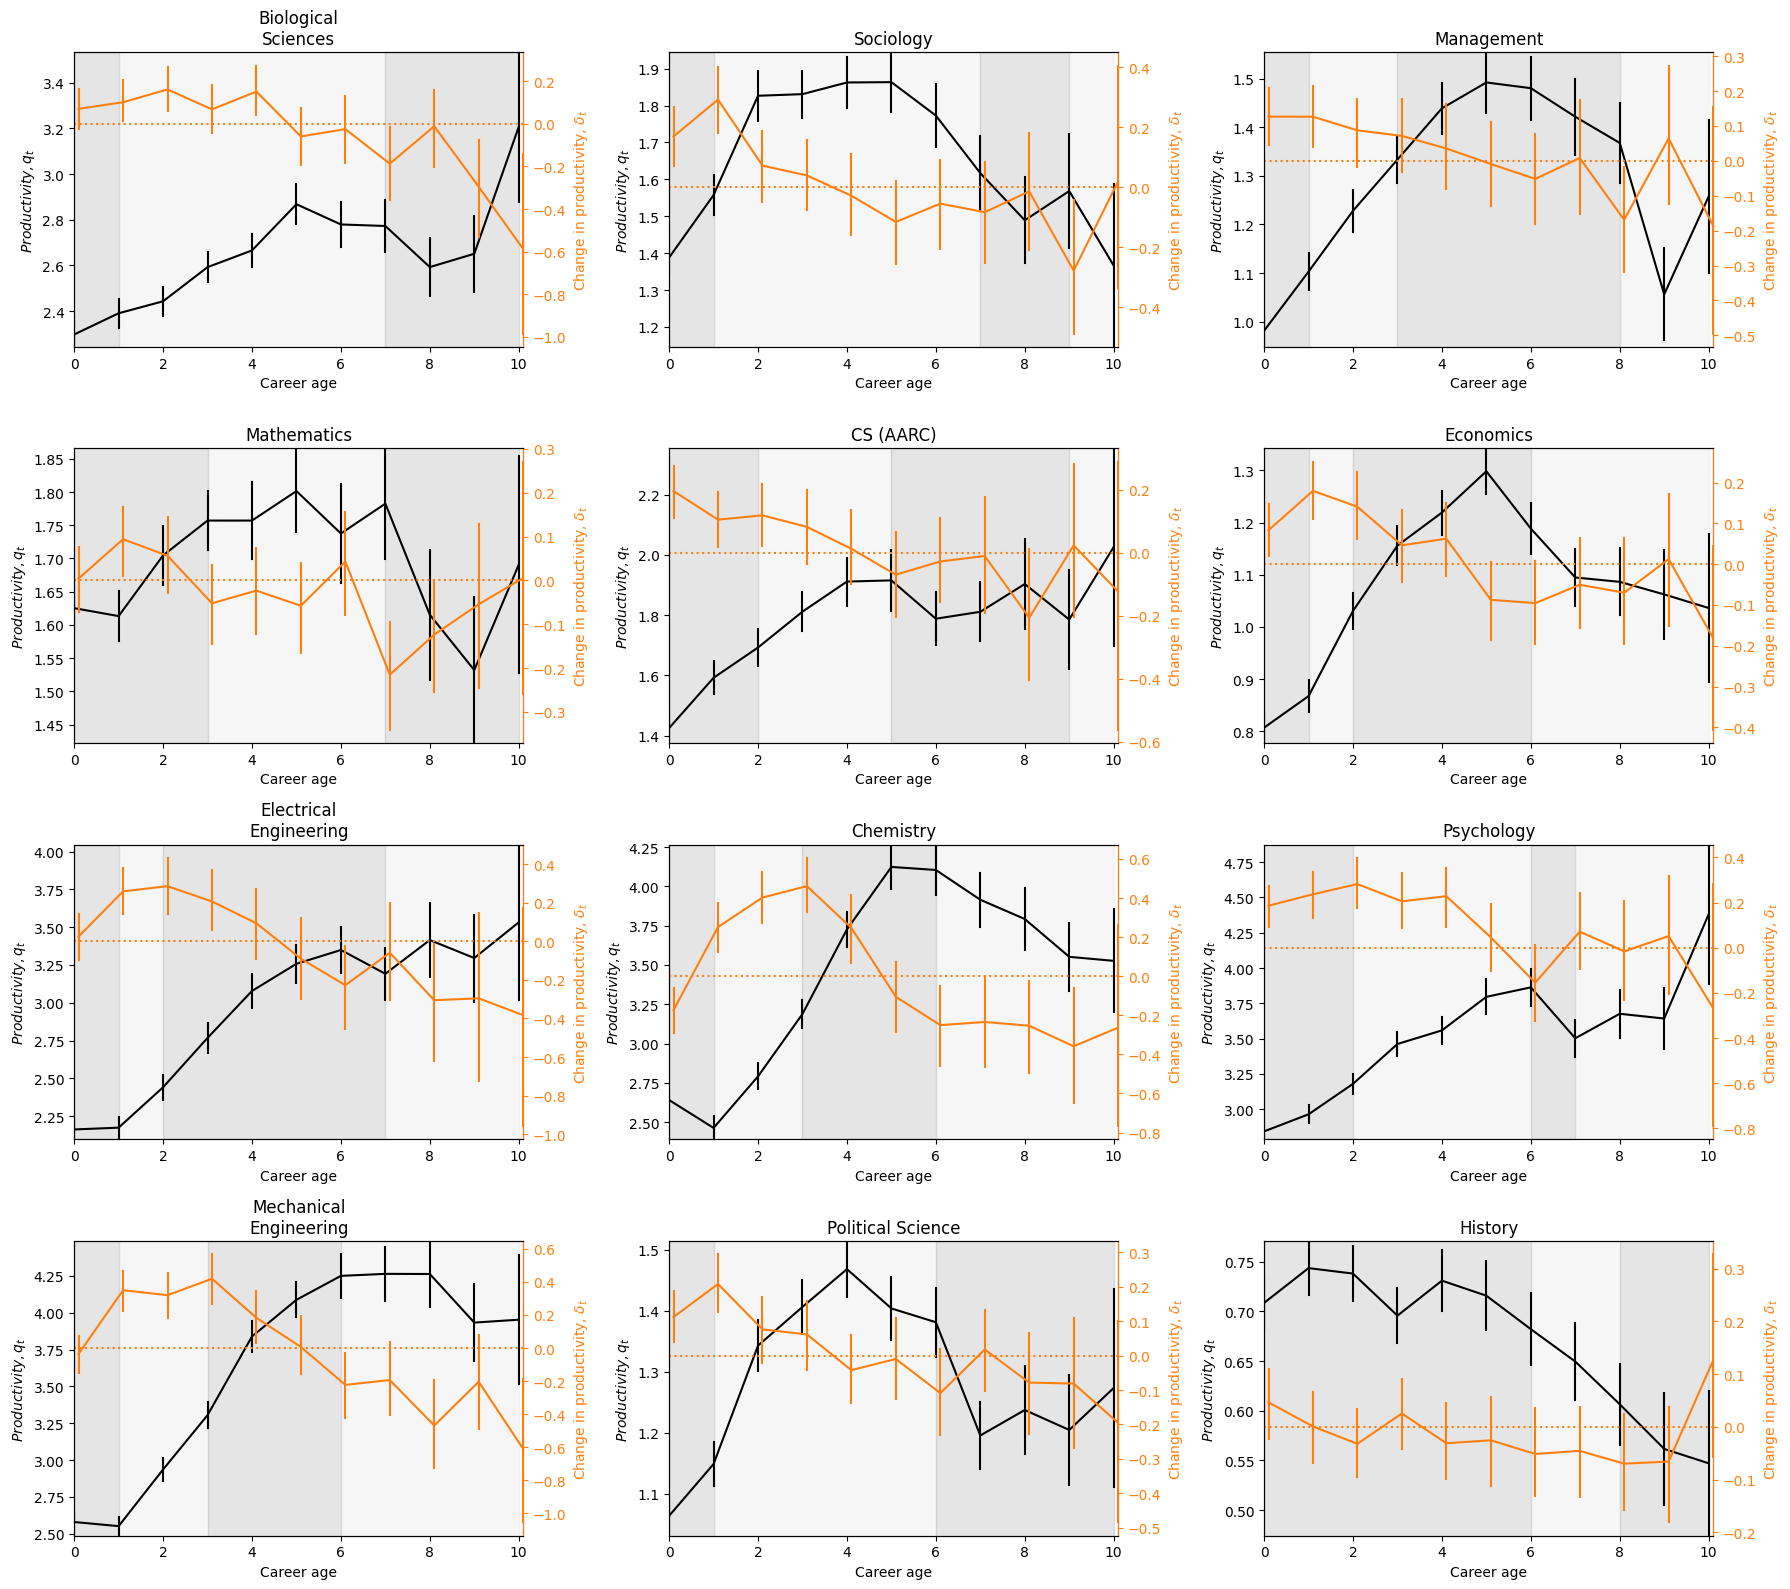

In [18]:
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for field, ax in zip(fields_to_display_names.keys(), axes):
    df_field = aarc[field]['trajectories'].copy()

    df_field['CareerAgeZeroShifted'] = df_field['CareerAgeZero'] + 0.1
    cutoffs = aarc[field]['mle_cutoffs']

    sns.lineplot(data=df_field, x='CareerAgeZero', y='pubs_adj', ax=ax, color='black', err_style='bars', errorbar='se') #err_kws={'alpha': 0.05})
    
    ax.margins(0)

    ax.set_ylabel(r"$Productivity, q_t$")
    
    ax.set_xlabel("Career age")
    ax.set_title(aarc[field]['display_field'])
    
    for i, (start, end) in enumerate(zip((0,) + cutoffs, cutoffs + (10,))):
        ax.axvspan(start, end, alpha=0.2, color='gray' if i%2 == 0 else 'lightgray')

    # Twin axis
    
    ax2 = ax.twinx()
    sns.lineplot(data=df_field, x='CareerAgeZeroShifted', y='q_adj_delta', ax=ax2, color=sns.color_palette()[1], err_style='bars') #err_kws={'alpha': 0.05})
    ax2.axhline(0, color=sns.color_palette()[1], linestyle=':')
    ax2.set_ylabel(r"Change in productivity, $\delta_t$", color=sns.color_palette()[1])
    ax2.tick_params(axis="y", colors=sns.color_palette()[1])
    ax2.spines["right"].set_color(sns.color_palette()[1])

    
plt.tight_layout()
plt.savefig(here("output/resubmission/aarc_trajectories.pdf"), bbox_inches="tight")

# Tenure analysis

Looking at whether tenure transitions better explain productivity patterns.

In [19]:
all_dfs = []

df_promotions = pd.concat([aarc[field]['promotions'] for field in aarc.keys()])

print(f"Across all fields, we have {df_promotions.PersonId.nunique()} people, and {len(df_promotions)} person-year rows.")

Across all fields, we have 808 people, and 8043 person-year rows.


Which explains more variance in the productivity: the career age, or the time-to-tenure age?

In other words, for every given career/time-to-tenure age $t$, what is the variance of productivities around it?

In [20]:
df_promotions.head()

,PersonId,Year,pubs_adj,StartYear,Field,CareerAgeZero,HasPublications,pubs_adj_next,q_adj_delta,Rank,NextYearsRank,WasPromotedFromAssistant,CareerAgePromoted,TenureAge
0,774,2013,7.0,2013,Biological Sciences,0,True,5.0,-2.0,Assistant Professor,Associate Professor,True,0,0
1,774,2014,5.0,2013,Biological Sciences,1,True,6.0,1.0,Associate Professor,Associate Professor,False,0,1
2,774,2015,6.0,2013,Biological Sciences,2,True,6.0,0.0,Associate Professor,Associate Professor,False,0,2
3,774,2016,6.0,2013,Biological Sciences,3,True,4.0,-2.0,Associate Professor,Associate Professor,False,0,3
4,774,2017,4.0,2013,Biological Sciences,4,True,5.0,1.0,Associate Professor,Associate Professor,False,0,4


In [21]:
career_age_stds = df_promotions.groupby('CareerAgeZero').pubs_adj.std()
tenure_age_stds = df_promotions[df_promotions.TenureAge.abs() <= 5].groupby('TenureAge').pubs_adj.std()

In [22]:
len(career_age_stds), len(tenure_age_stds)

(11, 11)

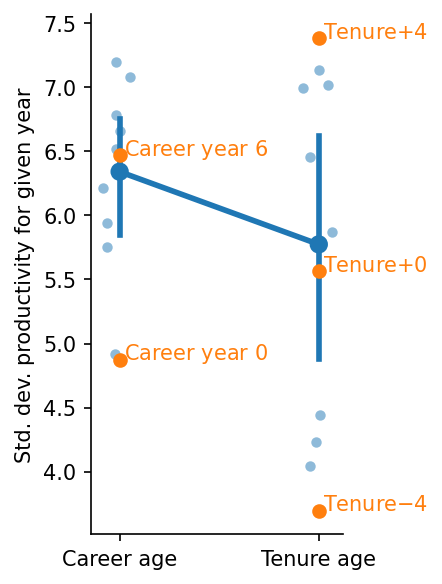

In [25]:
np.random.seed(1010)

df_career_age_stds = career_age_stds.reset_index()
df_career_age_stds['type'] = 'Career age'

df_tenure_age_stds = tenure_age_stds.reset_index()
df_tenure_age_stds['type'] = 'Tenure age'

df_stds = pd.concat([df_career_age_stds, df_tenure_age_stds])

career_ages_to_plot = [0, 6]
tenure_ages_to_plot = [-4, 0, 4]
df_stds_plot = df_stds[
    (~df_stds.CareerAgeZero.isin(career_ages_to_plot)) &
    (~df_stds.TenureAge.isin(tenure_ages_to_plot))
]

fig, ax = plt.subplots(1, 1, figsize=(3, 4), dpi=150)

sns.stripplot(data=df_stds_plot, x='type', y='pubs_adj', ax=ax, alpha=0.5)
sns.pointplot(data=df_stds_plot, x='type', y='pubs_adj', ax=ax)

for age in career_ages_to_plot:
    ax.scatter(0, df_stds[df_stds.CareerAgeZero == age].pubs_adj, color=sns.color_palette()[1], zorder=3)
    ax.annotate(f"Career year ${age}$", (0.02, df_stds[df_stds.CareerAgeZero == age].pubs_adj), color=sns.color_palette()[1], zorder=3)

for age in tenure_ages_to_plot:
    ax.scatter(1, df_stds[df_stds.TenureAge == age].pubs_adj, color=sns.color_palette()[1], zorder=3)
    ax.annotate(f"Tenure${age:+d}$", (1.02, df_stds[df_stds.TenureAge == age].pubs_adj), color=sns.color_palette()[1], zorder=3)


ax.set_xlabel(None)
ax.set_ylabel("Std. dev. productivity for given year")
sns.despine()
plt.tight_layout()

plt.savefig(here("output/resubmission/career_age_vs_tenure_age.pdf"), bbox_inches="tight")

# Time-based simulations

## Model 1: Exponential distribution around shifting mean

We will use a piecewise linear regression, following Way et al (2017), for the mean. First, we need to fit it to the overall mean. We have some tools in `fit/src/lib_canonical.py` for this but they were designed for fitting individual trajectories, not the entire aggregate, so we will modify them here to do what we want.

In [30]:
import statsmodels.api as sm

def aicc(mod_result):
    return sm.tools.eval_measures.aicc(mod_result.llf, mod_result.nobs, mod_result.df_model)


def fit_linear(df_traj):
    model_linear = sm.OLS(
        df_traj['pubs_adj'].values,
        sm.add_constant(df_traj['CareerAgeZero']),
    )

    results_linear = model_linear.fit()
    return aicc(results_linear)


def fit_piecewise_linear(df_traj, t, verbose=False):
    traj_before_t = df_traj[df_traj.CareerAgeZero <= t]
    traj_after_t = df_traj[df_traj.CareerAgeZero > t]

    model_breakpoint_before_t = sm.OLS(
        traj_before_t['pubs_adj'].values,
        sm.add_constant(traj_before_t.CareerAgeZero.values),
    )

    results_breakpoint_before_t = model_breakpoint_before_t.fit()

    model_breakpoint_after_t = sm.OLS(
        traj_after_t['pubs_adj'].values,
        sm.add_constant(traj_after_t['CareerAgeZero']),
    )

    results_breakpoint_after_t = model_breakpoint_after_t.fit()

    #breakpoint_aic = -2*(results_breakpoint_after_t.llf + results_breakpoint_before_t.llf) + 8
    breakpoint_aicc = sm.tools.eval_measures.aicc(results_breakpoint_after_t.llf + results_breakpoint_before_t.llf, df_traj.CareerAgeZero.nunique(), 4)
    if verbose:
        print(f"Before SSE:{results_breakpoint_before_t.mse_total}*{results_breakpoint_before_t.nobs}, After MSE: {results_breakpoint_after_t.mse_total}*{results_breakpoint_after_t.nobs}")

    return {
        'aicc': breakpoint_aicc,
        'a1': results_breakpoint_before_t.params[0],
        'b1': results_breakpoint_before_t.params[1],
        'b2': results_breakpoint_after_t.params[1]
    }

def find_breakpoint(df_traj):
    df_traj = df_traj[df_traj.CareerAgeZero < 20]
    linear_aicc = fit_linear(df_traj)
    best_aicc = linear_aicc
    best_params = None
    best_tstar = -1

    for t in range(3, df_traj.CareerAgeZero.max() - 3):
        params = fit_piecewise_linear(df_traj, t)
        current_aicc = params['aicc']
        if current_aicc < best_aicc:
            best_aicc = current_aicc
            best_params = params
            best_tstar = t

    return best_tstar, best_params

In [31]:
df_traj_full = df_traj_all[df_traj_all.groupby('dblp_id').CareerAgeZero.transform('max') == 20]

In [32]:
changepoint, piecewise_params = find_breakpoint(df_traj_full)

changepoint, piecewise_params

(3,
 {'aicc': 77209.98764658377,
  'a1': 4.770562700182326,
  'b1': 0.9756640039474931,
  'b2': -0.059128436698813916})

In [33]:
# Fix parameters for a piecewise linear regression as a test

a1 = piecewise_params['a1']
b1 = piecewise_params['b1']

a2 = a1 + (changepoint) * b1
b2 = piecewise_params['b2']

data = []
scale = 1
N = 10000
for t in range(0, changepoint):
    avg_q_t = a1 + t*b1
    q_t_expon = stats.expon(loc=avg_q_t, scale=scale)
    q_t = q_t_expon.rvs(size=N)

    data.append({'year': t, 'productivity': q_t})

for t2 in range(changepoint, 20):
    t = t2 - changepoint
    avg_q_t = a2 + t*b2
    q_t_expon = stats.expon(loc=avg_q_t, scale=scale)
    q_t = q_t_expon.rvs(size=N)

    data.append({'year': t2, 'productivity': q_t})

df_data = pd.DataFrame(data)
df_expon_prod = df_data.explode(column='productivity')
df_expon_prod['Person'] = 20*list(range(sum(df_expon_prod.year == 0)))
df_expon_prod['ProductivityDelta'] = df_expon_prod.groupby('Person').productivity.transform('diff')


In [34]:
def dedup_legend(ax, **legend_settings):
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys(), **legend_settings)

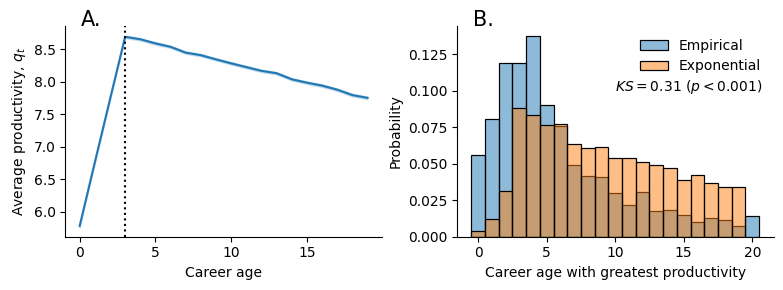

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

ax=axes[0]
sns.lineplot(data=df_expon_prod, x='year', y='productivity', ax=ax)
ax.axvline(3, linestyle=':', color='black')
ax.set_xlabel("Career age")
ax.set_ylabel("Average productivity, $q_t$")
ax.text(0.05, 1, "A.", fontsize=15, transform=ax.transAxes)

ax=axes[1]
most_productive_year_empirical = df_traj_all[['dblp_id', 'pubs_adj', 'CareerAgeZero']].sort_values(by=['dblp_id', 'pubs_adj'], ascending=False).groupby('dblp_id').CareerAgeZero.first()
most_productive_year_expon = df_expon_prod.sort_values(by=['Person', 'productivity'], ascending=False).groupby('Person').year.first()

ks_results = stats.ks_2samp(most_productive_year_empirical, most_productive_year_expon)

sns.histplot(most_productive_year_empirical, ax=ax, alpha=0.5, stat="probability", label='Empirical', discrete=True)
sns.histplot(most_productive_year_expon, ax=ax, alpha=0.5, stat="probability", label='Exponential', discrete=True)

dedup_legend(ax, loc='upper right', frameon=False)

ax.text(10, 0.1, f"$KS={ks_results.statistic:.2f}$ ($p<0.001$)")

ax.set_xlabel("Career age with greatest productivity")
ax.text(0.05, 1, "B.", fontsize=15, transform=ax.transAxes)

plt.tight_layout()
sns.despine()

plt.savefig(here("output/resubmission/minimal_model1.pdf"), bbox_inches="tight")

## Model 2: Basket of projects

In [36]:
N = 5000
T_max = 20

def check_project_exhaustion(timesteps_with_maturations, T_max):
    """
    Check if any individual has exhausted all projects before reaching T_max.
    
    :param timesteps_with_maturations: Array containing the timesteps when projects mature.
    :param T_max: The maximum timestep.
    :return: Boolean indicating if any individual has exhausted projects, and a list of such individuals.
    """
    # Check if the last maturity time for each project slot is less than T_max
    last_maturations = timesteps_with_maturations[:, :, -1]
    individuals_exhausted = np.any(last_maturations < T_max, axis=1)

    return np.any(individuals_exhausted), np.where(individuals_exhausted)[0]


def simulate(K, lam):
    # Step 1: Generate a large number of Poisson random variables for gaps
    max_projects = 40  # Arbitrarily large to ensure we don't run out
    gaps = stats.poisson.rvs(lam, size=(N, K, max_projects))

    # Step 2: Cumulatively sum the gaps to get timesteps with maturations
    timesteps_with_maturations = gaps.cumsum(axis=-1)


    has_exhausted, exhausted_individuals = check_project_exhaustion(timesteps_with_maturations, T_max)
    
    if has_exhausted:
        print(f"Warning: exhaustion reached for {len(exhausted_individuals)} individuals")

    # Filter out values larger than T_max
    valid_indices = timesteps_with_maturations < T_max

    # Convert valid timesteps to 1s (indicating productivity)
    productivity_increments = np.where(valid_indices, 1, 0)

    # Construct an empty array for the productivity matrix
    prods = np.zeros((N, T_max), dtype=int)

    # Use advanced indexing to mark productivity
    for i in range(N):
        for j in range(K):
            prods[i, timesteps_with_maturations[i, j, valid_indices[i, j]]] += productivity_increments[i, j, valid_indices[i, j]]

    # Keep track of the individuals
    df_prod = pd.DataFrame(prods).reset_index().rename(columns={'index': 'Person'})
    df = df_prod.melt(id_vars='Person', var_name="Year", value_name="Productivity")
    df['ProductivityDelta'] = df.groupby('Person').Productivity.transform('diff')
    
    return df

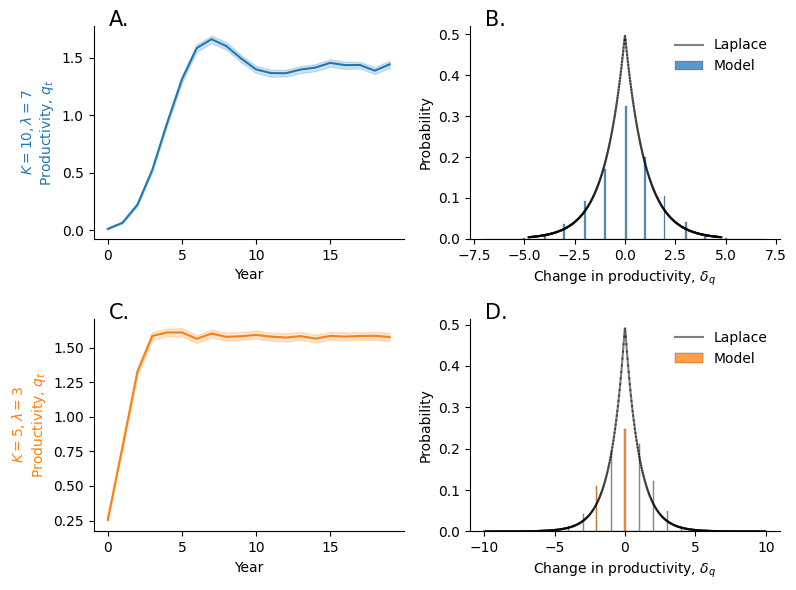

In [38]:
def plot_deltas_vs_laplace(dataframe, bound, c=None, ax=None):
    deltas = dataframe.dropna().ProductivityDelta
    fitted_params = stats.laplace.fit(deltas)
    
    sns.histplot(deltas, stat='probability', ax=ax, color=c, label='Model')
    fitted = stats.laplace(fitted_params)
    drawn_label = False
    for x1, x2 in zip(np.linspace(-bound, bound, num=500), np.linspace(-bound, bound, num=500)[1:]):
        if not drawn_label:
            label = 'Laplace'
            drawn_label = True
        else:
            label = None
            
        ax.plot(
            [x1, x2],
            [fitted.pdf(x1)[0], fitted.pdf(x2)[0]],
        alpha=0.5, color='black', label=label)
    
    ax.set_xlabel("Change in productivity, $\delta_q$")
    dedup_legend(ax, loc='upper right', frameon=False)
    


K1 = 10
L1 = 7

K2 = 5
L2 = 3

df1 = simulate(K1, L1)
df2 = simulate(K2, L2)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

ax = axes[0][0]
sns.lineplot(df1, x="Year", y="Productivity", ax=ax)
#ax.text(10, 0.6, "$K=5, \lambda=3$")
ax.set_ylabel(f"$K={K1}, \lambda={L1}$\nProductivity, $q_t$", color=sns.color_palette()[0])
ax.text(0.05, 1, "A.", fontsize=15, transform=ax.transAxes)

ax = axes[0][1]
plot_deltas_vs_laplace(df1, bound=4.8, ax=ax)
ax.text(0.05, 1, "B.", fontsize=15, transform=ax.transAxes)

ax = axes[1][0]
sns.lineplot(df2, x="Year", y="Productivity", c=sns.color_palette()[1], ax=ax)
#ax.text(10, 3, "$K=100, \lambda=10$")
ax.set_ylabel(f"$K={K2}, \lambda={L2}$\nProductivity, $q_t$", color=sns.color_palette()[1])
ax.text(0.05, 1, "C.", fontsize=15, transform=ax.transAxes)

ax = axes[1][1]
plot_deltas_vs_laplace(df2, bound=10, c=sns.color_palette()[1], ax=ax)
ax.text(0.05, 1, "D.", fontsize=15, transform=ax.transAxes)

plt.tight_layout()
sns.despine()

plt.savefig(here("output/resubmission/minimal_model2.pdf"), bbox_inches="tight")

# Shockley model?

Whether productivity follows a log-normal distribution.

[]

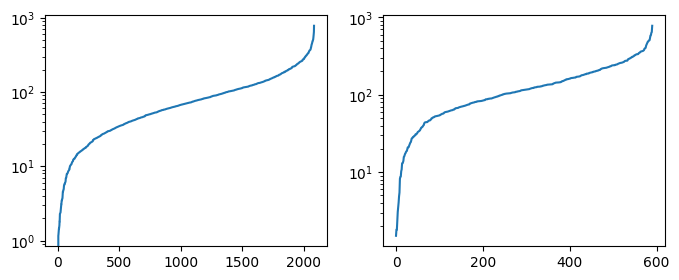

In [40]:
all_prods = df_traj_all.groupby('dblp_id').pubs_adj.sum().sort_values()
full_prods = df_traj_full.groupby('dblp_id').pubs_adj.sum().sort_values()

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

ax = axes[0]
ax.plot(range(len(all_prods)), all_prods)
ax.semilogy()

ax = axes[1]
ax.plot(range(len(full_prods)), full_prods)
ax.semilogy()

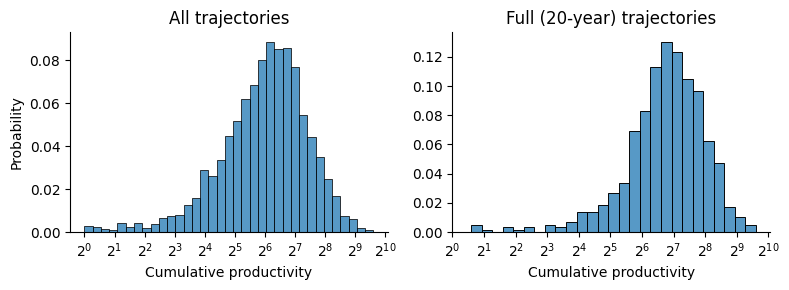

In [205]:
import numpy as np

def add_log_ticks(ax, tick_min, tick_max, base):
    ticks = np.arange(tick_min, tick_max)
    ax.set_xticks(ticks)
    ax.set_xticklabels([f"${base}^{{{int(t)}}}$" for t in ticks])

all_prods = df_traj_all.groupby('dblp_id').pubs_adj.sum().sort_values()
all_prods_log = np.log2(np.maximum(all_prods, 1))

full_prods = df_traj_full.groupby('dblp_id').pubs_adj.sum().sort_values()
full_prods_log = np.log2(full_prods)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

ax = axes[0]

sns.histplot(all_prods_log, stat="probability", ax=ax)
#all_norm = stats.norm(loc=
ax.set_title("All trajectories")
ax.set_xlabel("Cumulative productivity")
add_log_ticks(ax, 0, np.ceil(all_prods_log.max()) + 1, base=2)

ax = axes[1]
sns.histplot(full_prods_log, stat="probability", ax=ax)
ax.set_xlabel("Cumulative productivity")
ax.set_ylabel(None)
ax.set_title("Full (20-year) trajectories")
add_log_ticks(ax, 0, np.ceil(full_prods_log.max()) + 1, base=2)

plt.tight_layout()
sns.despine()

In [60]:
with open(here("input/simulate/simulated-all.pickle"), "rb") as f:
    dblp_simulations = pickle.load(f)

with open(here("input/simulate/simulated-full.pickle"), "rb") as f:
    dblp_simulations_full = pickle.load(f)

print(dblp_simulations.keys())

dict_keys(['trajs', 'df_trajs', 'cutoffs'])


In [115]:
c3 = "#FC7753"

## Generate simplified trajectories for lognormal test

In [533]:
import sys

sys.path.append(str(here("../fit/src").resolve()))

from lib_fit_models import simulate_trajectories_using_fixed_mode, simulate_trajectories_using_mode_regression, sample_trunc_laplace

In [538]:
def make_parameters(alpha1, alpha2):
    return [
        {'cutoffs': (4, ), 'cutoff_start': 0, 'cutoff_end': 4, 'alpha': alpha1, 'mode_beta': 0.75},
        {'cutoffs': (4, ), 'cutoff_start': 4, 'cutoff_end': np.inf, 'alpha': alpha2, 'mode_beta': 0.75},
    ]

global_mode_fixed = -1
alpha_q0 = 4.65

np.random.seed(1010)

pure_laplace_trajectories = simulate_trajectories_using_fixed_mode(make_parameters(4.7, 4.7), alpha_q0, global_mode=global_mode_fixed, n=10000)
semi_canonical_trajectories = simulate_trajectories_using_fixed_mode(make_parameters(4.7, 2.4), alpha_q0, global_mode=global_mode_fixed, n=10000)

np.random.seed(1010)
alpha_q0_big = 46.5

pure_laplace_trajectories_big = simulate_trajectories_using_fixed_mode(make_parameters(47, 47), alpha_q0_big, global_mode=global_mode_fixed, n=10000)
semi_canonical_trajectories_big = simulate_trajectories_using_fixed_mode(make_parameters(47, 24), alpha_q0_big, global_mode=global_mode_fixed, n=10000)

log_pure_laplace = np.log2(pure_laplace_trajectories.sum(axis=0))
log_semi_canon = np.log2(semi_canonical_trajectories.sum(axis=0))

log_pure_laplace_big = np.log2(pure_laplace_trajectories_big.sum(axis=0))
log_semi_canon_big = np.log2(semi_canonical_trajectories_big.sum(axis=0))

In [539]:
np.random.seed(1010)

pure_laplace_trajectories_beta = simulate_trajectories_using_mode_regression(make_parameters(4.7, 4.7), alpha_q0, n=10000)
semi_canonical_trajectories_beta = simulate_trajectories_using_mode_regression(make_parameters(4.7, 2.4), alpha_q0, n=10000)

log_pure_laplace_beta = np.log2(pure_laplace_trajectories_beta.sum(axis=0))
log_semi_canon_beta = np.log2(semi_canonical_trajectories_beta.sum(axis=0))

In [163]:
c4 = '#6CAE75'

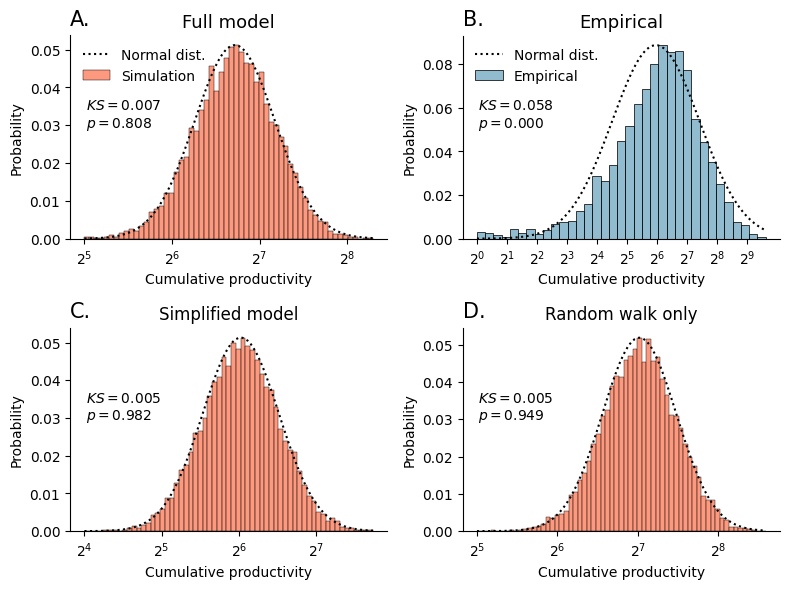

In [540]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

np.random.seed(1010)

def plot_cum_prod_vs_norm(ax, log_prods, hist_label, legend_loc='upper left', show_legend=True, color=c1):
    scale = np.std(log_prods)
    
    norm_cum_sims = stats.norm(loc=np.mean(log_prods), scale=scale)
    norm_cum_sims_rv = norm_cum_sims.rvs(size=(len(log_prods)*10, 1))[:,0]
    norm_ks = stats.ks_2samp(log_prods, norm_cum_sims_rv)
    #norm_k2 = stats.normaltest(log_prods)
    
    sns.histplot(log_prods, stat='probability', ax=ax, label=hist_label, color=color)
    max_y = max([patch.get_height() for patch in ax.patches])

    xmin = log_prods.min()
    xmax = log_prods.max()
    grid = np.linspace(xmin, xmax, 100)

    ys = np.array([norm_cum_sims.pdf(x) for x in grid])
    scale_factor = max(ys) / max_y

    ys_scale = ys / scale_factor
    
    ax.plot(grid, ys_scale, c="black", linestyle=":", label="Normal dist.")
    if show_legend:
        dedup_legend(ax, loc=legend_loc, frameon=False)
    
    ax.text(0.05, 0.55, f"$KS={norm_ks.statistic:.3f}$\n$p={norm_ks.pvalue:.3f}$", transform=ax.transAxes)
    #ax.text(0.05, 0.55, f"$K^2={norm_k2.statistic:.3f}$\n$p={norm_k2.pvalue:.3f}$", transform=ax.transAxes)
    ax.set_xlabel("Cumulative productivity")
    
    add_log_ticks(ax, xmin, xmax, base=2)

ax = axes[0][0]
plot_cum_prod_vs_norm(ax, np.log2(dblp_simulations['trajs'].sum(axis=0)), hist_label="Simulation", color=c3)
ax.set_title("Full model", fontsize=13)
ax.text(0, 1.05, "A.", transform=ax.transAxes, fontsize=15)


ax = axes[0][1]
plot_cum_prod_vs_norm(ax, all_prods_log, "Empirical")
ax.text(0, 1.05, "B.", transform=ax.transAxes, fontsize=15)
ax.set_title("Empirical", fontsize=13)

ax = axes[1][0]
plot_cum_prod_vs_norm(ax, log_semi_canon_beta, show_legend=False, hist_label="Simulation", color=c3)
ax.set_title("Simplified model")
ax.text(0, 1.05, "C.", transform=ax.transAxes, fontsize=15)

ax = axes[1][1]
plot_cum_prod_vs_norm(ax, log_pure_laplace_beta, show_legend=False, hist_label="Simulation", color=c3)
ax.set_title("Random walk only")
ax.text(0, 1.05, "D.", transform=ax.transAxes, fontsize=15)

sns.despine()
plt.tight_layout()

plt.savefig(here("output/resubmission/shockley.pdf"), bbox_inches="tight")

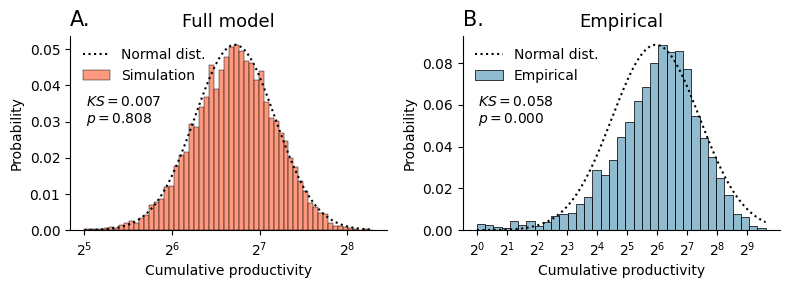

In [532]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

np.random.seed(1010)

def plot_cum_prod_vs_norm(ax, log_prods, hist_label, legend_loc='upper left', show_legend=True, color=c1):
    scale = np.std(log_prods)
    
    norm_cum_sims = stats.norm(loc=np.mean(log_prods), scale=scale)
    norm_cum_sims_rv = norm_cum_sims.rvs(size=(len(log_prods)*10, 1))[:,0]
    norm_ks = stats.ks_2samp(log_prods, norm_cum_sims_rv)
    #norm_k2 = stats.normaltest(log_prods)
    
    sns.histplot(log_prods, stat='probability', ax=ax, label=hist_label, color=color)
    max_y = max([patch.get_height() for patch in ax.patches])

    xmin = log_prods.min()
    xmax = log_prods.max()
    grid = np.linspace(xmin, xmax, 100)

    ys = np.array([norm_cum_sims.pdf(x) for x in grid])
    scale_factor = max(ys) / max_y

    ys_scale = ys / scale_factor
    
    ax.plot(grid, ys_scale, c="black", linestyle=":", label="Normal dist.")
    if show_legend:
        dedup_legend(ax, loc=legend_loc, frameon=False)
    
    ax.text(0.05, 0.55, f"$KS={norm_ks.statistic:.3f}$\n$p={norm_ks.pvalue:.3f}$", transform=ax.transAxes)
    #ax.text(0.05, 0.55, f"$K^2={norm_k2.statistic:.3f}$\n$p={norm_k2.pvalue:.3f}$", transform=ax.transAxes)
    ax.set_xlabel("Cumulative productivity")
    
    add_log_ticks(ax, xmin, xmax, base=2)

ax = axes[0]
plot_cum_prod_vs_norm(ax, np.log2(dblp_simulations['trajs'].sum(axis=0)), hist_label="Simulation", color=c3)
ax.set_title("Full model", fontsize=13)
ax.text(0, 1.05, "A.", transform=ax.transAxes, fontsize=15)


ax = axes[1]
plot_cum_prod_vs_norm(ax, all_prods_log, "Empirical")
ax.text(0, 1.05, "B.", transform=ax.transAxes, fontsize=15)
ax.set_title("Empirical", fontsize=13)

sns.despine()
plt.tight_layout()

plt.savefig(here("output/resubmission/shockley.pdf"), bbox_inches="tight")

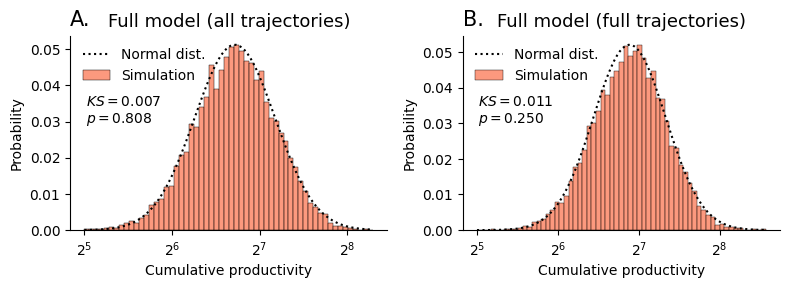

In [210]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

np.random.seed(1010)

ax = axes[0]
plot_cum_prod_vs_norm(ax, np.log2(dblp_simulations['trajs'].sum(axis=0)), hist_label="Simulation", color=c3)
ax.set_title("Full model (all trajectories)", fontsize=13)
ax.text(0, 1.05, "A.", transform=ax.transAxes, fontsize=15)

ax = axes[1]
plot_cum_prod_vs_norm(ax, np.log2(dblp_simulations_full['trajs'].sum(axis=0)), hist_label="Simulation", color=c3)
ax.set_title("Full model (full trajectories)", fontsize=13)
ax.text(0, 1.05, "B.", transform=ax.transAxes, fontsize=15)

sns.despine()
plt.tight_layout()

plt.savefig(here("output/resubmission/shockley_all_vs_full.pdf"), bbox_inches="tight")

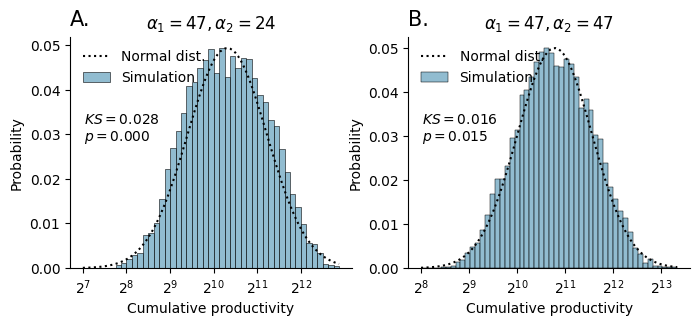

In [211]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

ax = axes[0]
plot_cum_prod_vs_norm(ax, log_semi_canon_big, "Simulation")
ax.set_title("$\\alpha_1=47, \\alpha_2=24$")
ax.text(0, 1.05, "A.", transform=ax.transAxes, fontsize=15)

ax = axes[1]
plot_cum_prod_vs_norm(ax, log_pure_laplace_big, "Simulation")
ax.set_title("$\\alpha_1=47, \\alpha_2=47$")
ax.text(0, 1.05, "B.", transform=ax.transAxes, fontsize=15)

sns.despine()

# Skewness and kurtosis

In [526]:
def block_bootstrap_skew_kurtosis(dataframe, person_col, output_col, n_boots=1000, seed=1010):
    np.random.seed(seed)
    
    skews = []
    kurts = []
    
    unique_people = dataframe[person_col].unique()
    
    for _ in range(n_boots):
        sampled_people = np.random.choice(unique_people, size=len(unique_people), replace=True)
        boot_df = dataframe[dataframe[person_col].isin(sampled_people)]
        arr = boot_df[output_col].values
        
        skews.append(stats.skew(arr))
        kurts.append(stats.kurtosis(arr))
    
    return skews, kurts

def bootstrap_skew_kurtosis(arr, n_boots=1000, seed=1010):
    np.random.seed(seed)
    
    skews = []
    kurts = []
    for _ in range(n_boots):
        boots = np.random.choice(arr, size=len(arr))
        skews.append(stats.skew(boots))
        kurts.append(stats.kurtosis(boots))

    return skews, kurts

### 1-4

In [527]:
samp = df_traj_all[
    (df_traj_all.CareerAge >= 1) &
    (df_traj_all.CareerAge <= 4)
]

skews, kurts = block_bootstrap_skew_kurtosis(samp, "dblp_id", "q_adj_delta")

print(f"""
Skewness: {stats.skew(samp.q_adj_delta)} (95% bootstrap CI: [{np.quantile(skews, [0.025, 0.975])}])
Kurtosis: {stats.kurtosis(samp.q_adj_delta)} (95% bootstrap CI: [{np.quantile(kurts, [0.025, 0.975])}])
""")



Skewness: 0.2318923313175642 (95% bootstrap CI: [[0.13302856 0.32694012]])
Kurtosis: 2.2917979207413905 (95% bootstrap CI: [[1.82743913 2.66184382]])



In [528]:
deltas_sim = (dblp_simulations['trajs'][2:6,:] - dblp_simulations['trajs'][1:5,:])
deltas_sim_flat = np.reshape(deltas_sim, deltas_sim.shape[0] * deltas_sim.shape[1])

skews, kurts = bootstrap_skew_kurtosis(deltas_sim_flat)

print(f"""
Skewness: {stats.skew(deltas_sim_flat)} (95% bootstrap CI: [{np.quantile(skews, [0.025, 0.975])}])
Kurtosis: {stats.kurtosis(deltas_sim_flat)} (95% bootstrap CI: [{np.quantile(kurts, [0.025, 0.975])}])
""")


Skewness: 0.7645491365097624 (95% bootstrap CI: [[0.69611887 0.83402351]])
Kurtosis: 2.9982488173019197 (95% bootstrap CI: [[2.67041284 3.33188158]])



### 5-7

In [529]:
samp = df_traj_all[
    (df_traj_all.CareerAge >= 5) &
    (df_traj_all.CareerAge <= 7)
]

skews, kurts = block_bootstrap_skew_kurtosis(samp, "dblp_id", "q_adj_delta")

print(f"""
Skewness: {stats.skew(samp.q_adj_delta)} (95% bootstrap CI: [{np.quantile(skews, [0.025, 0.975])}])
Kurtosis: {stats.kurtosis(samp.q_adj_delta)} (95% bootstrap CI: [{np.quantile(kurts, [0.025, 0.975])}])
""")


Skewness: 0.1409791653407259 (95% bootstrap CI: [[0.02365735 0.24572607]])
Kurtosis: 2.360142416232704 (95% bootstrap CI: [[1.73486696 2.8335068 ]])



In [521]:
deltas_sim = (dblp_simulations['trajs'][6:9,:] - dblp_simulations['trajs'][5:8,:])
deltas_sim_flat = np.reshape(deltas_sim, deltas_sim.shape[0] * deltas_sim.shape[1])

skews, kurts = bootstrap_skew_kurtosis(deltas_sim_flat)

print(f"""
Skewness: {stats.skew(deltas_sim_flat)} (95% bootstrap CI: [{np.quantile(skews, [0.025, 0.975])}])
Kurtosis: {stats.kurtosis(deltas_sim_flat)} (95% bootstrap CI: [{np.quantile(kurts, [0.025, 0.975])}])
""")


Skewness: 0.6886890989535276 (95% bootstrap CI: [[0.60600544 0.7755207 ]])
Kurtosis: 2.9414558678183162 (95% bootstrap CI: [[2.51215031 3.50720699]])



### 8-end

In [530]:
samp = df_traj_all[
    (df_traj_all.CareerAge >= 8)
]

skews, kurts = block_bootstrap_skew_kurtosis(samp, "dblp_id", "q_adj_delta")

print(f"""
Skewness: {stats.skew(samp.q_adj_delta)} (95% bootstrap CI: [{np.quantile(skews, [0.025, 0.975])}])
Kurtosis: {stats.kurtosis(samp.q_adj_delta)} (95% bootstrap CI: [{np.quantile(kurts, [0.025, 0.975])}])
""")


Skewness: 0.03352805990883457 (95% bootstrap CI: [[-0.05369321  0.12314445]])
Kurtosis: 4.024377395771178 (95% bootstrap CI: [[3.30241533 4.59926295]])



In [520]:
deltas_sim = (dblp_simulations['trajs'][9:,:] - dblp_simulations['trajs'][8:-1,:])
deltas_sim_flat = np.reshape(deltas_sim, deltas_sim.shape[0] * deltas_sim.shape[1])

skews, kurts = bootstrap_skew_kurtosis(deltas_sim_flat)

print(f"""
Skewness: {stats.skew(deltas_sim_flat)} (95% bootstrap CI: [{np.quantile(skews, [0.025, 0.975])}])
Kurtosis: {stats.kurtosis(deltas_sim_flat)} (95% bootstrap CI: [{np.quantile(kurts, [0.025, 0.975])}])
""")


Skewness: 0.7211841789538191 (95% bootstrap CI: [[0.67928795 0.76010442]])
Kurtosis: 2.928775330249941 (95% bootstrap CI: [[2.72376559 3.14324435]])



# Predictive checks

Does our model do a better job of predicting next-year productivity compared to a simple baseline of just using the previous year's productivity?

In [223]:
results_dblp['df_reg_scores'].sort_values(by='aic_varying')

,cutoffs,nll_mode,nll_mode_fixed,n,min_n,num_cutoffs,k_varying,k_fixed,aic_varying,aic_fixed,bic_varying,bic_fixed
499,"(4, 7, 13)",80746.052684,80951.665619,"[8015, 5625, 8923, 5965]",5625,3,12,8,80758.052684,80959.665619,80750.211567,80954.438208
497,"(4, 7, 11)",80746.371078,80947.788715,"[8015, 5625, 6355, 8533]",5625,3,12,8,80758.371078,80955.788715,80750.529961,80950.561303
498,"(4, 7, 12)",80746.799436,80949.000338,"[8015, 5625, 7695, 7193]",5625,3,12,8,80758.799436,80957.000338,80750.958319,80951.772926
501,"(4, 7, 15)",80747.324970,80951.601894,"[8015, 5625, 11033, 3855]",3855,3,12,8,80759.324970,80959.601894,80751.483853,80954.374483
496,"(4, 7, 10)",80747.420947,80945.739665,"[8015, 5625, 4909, 9979]",4909,3,12,8,80759.420947,80953.739665,80751.579830,80948.512254
...,...,...,...,...,...,...,...,...,...,...,...,...
1157,"(18, 19)",80886.828765,81053.176602,"[27187, 701, 640]",640,2,9,6,80895.828765,81059.176602,80889.947927,81055.256043
1154,"(17, 18, 19)",80883.867890,81050.061122,"[26419, 768, 701, 640]",640,3,12,8,80895.867890,81058.061122,80888.026773,81052.833710
171,"(1, 19)",80888.989196,81062.666304,"[1967, 25921, 640]",640,2,9,6,80897.989196,81068.666304,80892.108358,81064.745745
0,"(1,)",80895.398043,81067.037811,"[1967, 26561]",1967,1,6,4,80901.398043,81071.037811,80897.477485,81068.424105


In [268]:
results_dblp['regression_for_cutoffs'][(4, 7, 13)]

[{'cutoffs': (4, 7, 13),
  'cutoff_start': 0,
  'cutoff_end': 4,
  'alpha': 4.454494438788485,
  'mode_beta': 0.8059967932861997,
  'mode_mu': -0.37235745311448554,
  'nll_mode': 22029.39723486327,
  'nll_mode_fixed': 22155.408980756387,
  'n': 8015},
 {'cutoffs': (4, 7, 13),
  'cutoff_start': 4,
  'cutoff_end': 7,
  'alpha': 4.252503444287812,
  'mode_beta': 0.7253971090070338,
  'mode_mu': 0.0704976586740198,
  'nll_mode': 15397.188832419753,
  'nll_mode_fixed': 15410.774407646339,
  'n': 5625},
 {'cutoffs': (4, 7, 13),
  'cutoff_start': 7,
  'cutoff_end': 13,
  'alpha': 3.780789099441465,
  'mode_beta': 0.7266045155782034,
  'mode_mu': -0.625004889167954,
  'nll_mode': 23254.155656066534,
  'nll_mode_fixed': 23278.874268055184,
  'n': 8923},
 {'cutoffs': (4, 7, 13),
  'cutoff_start': 13,
  'cutoff_end': inf,
  'alpha': 3.5208431087765284,
  'mode_beta': 0.7542818885815511,
  'mode_mu': -0.020581464944633865,
  'nll_mode': 15123.923068321401,
  'nll_mode_fixed': 15165.220070743748,
 

In [269]:
fitted_betas = {}
fitted_alphas = {}

for cutoff_data in results_dblp['regression_for_cutoffs'][(4, 7, 13)]:
    for age in range(int(cutoff_data['cutoff_start']), int(min(21, cutoff_data['cutoff_end']))):
        fitted_betas[age] = cutoff_data['mode_beta']
        fitted_alphas[age] = cutoff_data['alpha']

In [465]:
def expectation_centered(alpha, c):
    """c is negative"""
    return (-c + alpha) * np.exp(c/alpha) / (2 - np.exp(c / alpha))

def expectation(alpha, c, beta):
    """c is negative"""

    shifted_c = c * (1 - beta)
    e_cent = expectation_centered(alpha, shifted_c)

    return e_cent + c * beta

def predicted_next_year_prod_old(row):
    return row.pubs_adj * fitted_betas[row.CareerAgeZero]

def predicted_next_year_prod(row):
    return row.pubs_adj + expectation(fitted_alphas[row.CareerAgeZero], -row.pubs_adj, fitted_betas[row.CareerAgeZero])

In [469]:
df_traj_all['pubs_adj_next_pred'] = df_traj_all.apply(predicted_next_year_prod, axis=1)
df_traj_all['pubs_adj_next_pred_increase'] = df_traj_all['pubs_adj_next_pred'] > df_traj_all['pubs_adj']

In [479]:
df_traj_all['prod_increases'] = df_traj_all['pubs_adj_next'] > df_traj_all['pubs_adj']

<AxesSubplot: xlabel='CareerAgeZero', ylabel='prod_increases'>

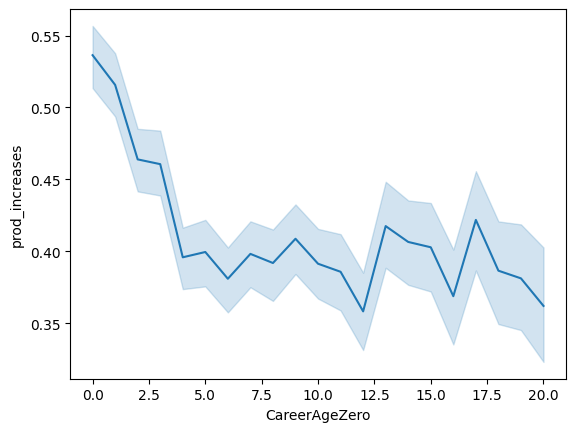

In [480]:
sns.lineplot(df_traj_all, x='CareerAgeZero', y='prod_increases')

In [485]:
len(df_traj_all[df_traj_all.pubs_adj > 50])

26

<AxesSubplot: xlabel='pubs_adj_next_pred', ylabel='pubs_adj_next'>

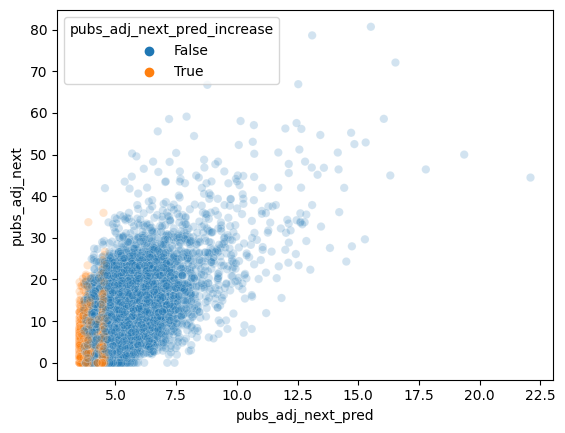

In [483]:
sns.scatterplot(data=df_traj_all, x='pubs_adj_next_pred', y='pubs_adj_next', hue='pubs_adj_next_pred_increase', alpha=0.2)

In [475]:
np.random.seed(1010)

errs_baseline = (df_traj_all.pubs_adj - df_traj_all.pubs_adj_next)**2
errs_preds = (df_traj_all.pubs_adj_next - df_traj_all.pubs_adj_next_pred)**2

N_bootstraps = 1000

rmse_baseline_boots = []
rmse_predictions_boots = []

for _ in range(N_bootstraps):
    errs_baseline_boot = np.random.choice(errs_baseline, size=len(errs_baseline), replace=True)
    errs_predictions_boot = np.random.choice(errs_preds, size=len(errs_preds), replace=True)
    rmse_baseline = np.sqrt(sum(errs_baseline_boot))
    rmse_predictions = np.sqrt(sum(errs_predictions_boot))

    rmse_baseline_boots.append(rmse_baseline)
    rmse_predictions_boots.append(rmse_predictions)

rmse_baseline_boot_quants = np.quantile(rmse_baseline_boots, [0.025, 0.5, 0.975])
rmse_predictions_boot_quants = np.quantile(rmse_predictions_boots, [0.025, 0.5, 0.975])

rmse_baseline_boot_avg = np.mean(rmse_baseline_boots)
rmse_predictions_boot_avg = np.mean(rmse_predictions_boots)

print(f"Baseline RMSE: {rmse_baseline_boot_avg:.2f} (95% bootstrap CI: [{rmse_baseline_boot_quants[0]:.2f}, {rmse_baseline_boot_quants[-1]:.2f}]); Prediction RMSE: {rmse_predictions_boot_avg:.2f} (95% bootstrap CI: [{rmse_predictions_boot_quants[0]:.2f}, {rmse_predictions_boot_quants[-1]:.2f}])")

Baseline RMSE: 837.96 (95% bootstrap CI: [827.19, 848.37]); Prediction RMSE: 1054.09 (95% bootstrap CI: [1035.66, 1071.96])
